In [230]:
!pip3 install saxpy

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp
import saxpy
import nltk
from nltk import bigrams
from nltk import trigrams
from saxpy.sax import sax_via_window
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [134]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy().set_index("DATETIME")
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/16 23", "16/09/16 00"],
    ["26/09/16 11", "27/09/16 10"],
    ["09/10/16 09", "11/10/16 20"],
    ["29/10/16 19", "02/11/16 16"],
    ["26/11/16 17", "29/11/16 04"],
    ["06/12/16 07", "10/12/16 04"],
    ["14/12/16 15", "19/12/16 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df2.reset_index(inplace=True)

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

df2['ATT_FLAG'] = new_attack_df2['ATT_FLAG']
dftest['ATT_FLAG'] = new_attack_df_test['ATT_FLAG']

In [135]:
def discretize(original_signal, paa_size=3, window_size=2, amount_of_levels=3):
    sax1 = sax_via_window(original_signal, window_size, paa_size, amount_of_levels)
    indices = []
    for k, v in sax1.items():
        indices.extend(v)
    indices.sort()
    discrete_signal = pd.DataFrame(index=indices, columns=["word"])
    for k, v in sax1.items():
        discrete_signal.loc[v] = k
    return discrete_signal

In [136]:
def get_trigram(discrete_signal):
    ts_string = " ".join(discrete_signal['word'])
    tokens = nltk.word_tokenize(ts_string)
    tri_tokens = trigrams(tokens)
    tri_list = [tuple(trigram) for trigram in tri_tokens]
    fdist = nltk.FreqDist(tri_list)
    trigram_df = pd.DataFrame.from_dict(fdist,orient='index')
    trigram_df_prob = trigram_df/trigram_df.sum()    
    try:
        return pd.Series(tri_list, index=discrete_signal.index[:-2]), trigram_df_prob[0]
    except:
        return None, None

In [265]:
## Select a target, discretize and see if it overlaps
# target_columns = df1.columns.drop(['DATETIME','ATT_FLAG']).tolist()
target_columns = ['F_PU6', 'S_PU6', 'F_PU11', 'S_PU11', 'F_PU7', 'S_PU7', 'P_J302',
       'P_J14', 'P_J307', 'L_T4', 'P_J317', 'L_T1', 'F_PU1', 'P_J269',
       'F_PU10', 'F_V2', 'S_PU10', 'P_J422', 'S_PU2']

alert_sum = []

paa_size=5
window_size=3
amount_of_levels=3

source_df = df1
target_df = df2

for target in target_columns:
    dat1 = source_df[target].values
    tris, triprob = get_trigram(discretize(dat1,paa_size,window_size,amount_of_levels))

    dat2 = target_df[target].values
    tris2, tris2prob = get_trigram(discretize(dat2,paa_size,window_size,amount_of_levels))
    
    if (triprob is None) and (tris2prob is None):
        continue
    
    threshold = min(triprob)
    if len(alert_sum) == 0:
        results = (tris2.apply(lambda x: triprob.get(x, -1))<=threshold).astype(int)
        alert_sum = results
    else:
        try:
            results = (tris2.apply(lambda x: triprob.get(x, -1))<=threshold).astype(int)
            alert_sum = alert_sum.add(results, fill_value=0)
        except:
            print("Couldn't do " + target)

Recall: 0.03048780487804878
Precision: 0.21428571428571427


[Text(0.5, 1.0, 'Attack predictions with paa=5, window=3, levels=3 and min 5 triggers')]

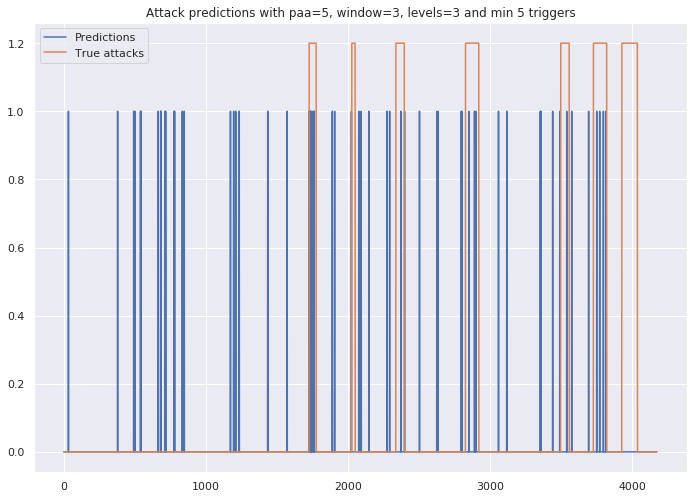

In [269]:
min_triggers = 5
predictions = alert_sum >= min_triggers
predictions = predictions.reindex(range(max(predictions.index))).ffill()

correct = target_df['ATT_FLAG'].eq(predictions)

truePositives = sum(correct[target_df['ATT_FLAG']==1])
trueNegatives = sum(correct[target_df['ATT_FLAG']==0])
falsePositives = sum((~correct)[target_df['ATT_FLAG']==0])
falseNegatives = sum((~correct)[target_df['ATT_FLAG']==1])

print("Recall: " + str(truePositives / (truePositives + falseNegatives)))
print("Precision: " + str(truePositives / (truePositives + falsePositives)))


fig, ax = plt.subplots()
sns.lineplot(data=predictions, ax=ax)
sns.lineplot(data=target_df['ATT_FLAG']*1.2, ax=ax)
ax.legend(["Predictions", "True attacks"])
ax.set(title="Attack predictions with paa="+str(paa_size) + ", window="+str(window_size)+", levels="+str(amount_of_levels) + " and min " + str(min_triggers) + " triggers")

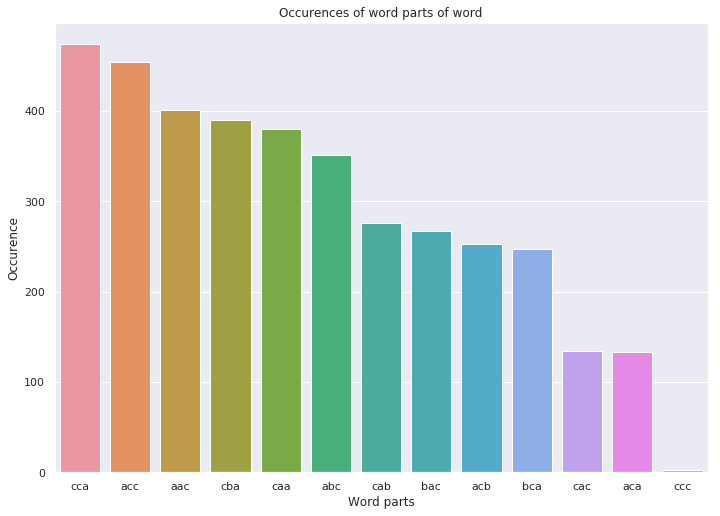

In [179]:
## Show example:
## Count the occurences of different words
discrete_signal = discretize(df2['F_PU1'].values, 3, 3)
word_counts = discrete_signal['word'].value_counts()

plot = sns.barplot(x='index', y='word',data=word_counts.reset_index())
plot.set_title("Occurences of word parts of {}".format("".join(discrete_signal[0:lent])));
plot.set_ylabel("Occurence");
plot.set_xlabel("Word parts");

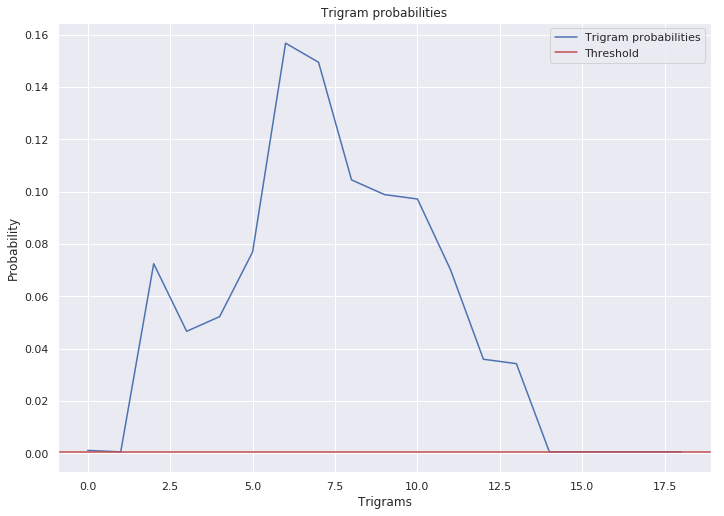

In [262]:
trigrams_df, trigram_df_prob = get_trigram(discretize(source_df["L_T1"].values))

fig = plt.figure()
ax = fig.add_subplot(111)
#arbitrary threshold value
threshold= min(trigram_df_prob)
sns.lineplot(data=trigram_df_prob.reset_index(drop=True).reset_index(), x="index", y=0, label = "Trigram probabilities",ax=ax)
ax.axhline(y=threshold, label='Threshold',color="r")
ax.set_title('Trigram probabilities')
ax.set_xlabel('Trigrams')
ax.set_ylabel('Probability')
ax.legend()
plt.show()